In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090b_hw2.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2025**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2pt">

In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [2]:
import random
random.seed(109)

import os
import sys
import time
import random # for displaying augmented image later on

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model, to_categorical

# import from keras modules stuff required for later parts
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.layers import Input, Dense, Concatenate, LeakyReLU, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import tensorflow.signal as tf_signal
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-03-05 22:17:26.419322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 22:17:26.419362: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 22:17:26.420071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 22:17:26.425164: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# measure notebook runtime
time_start = time.time()

<div style = "background: lightsalmon; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [50 pts]: Modeling and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [50 pts]: 'Quick, Draw!' Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The "Quick, Draw!" Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS1090B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [50 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

**Note that this part (section 1.1) has been completed for you. Simply run the provided cells below to load and preprocess the data. While you do not need to write any code here, you are expected to read through the processing steps taken here so that you fully understand the data you'll be working with.**


</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [5]:
df_flights = pd.read_csv("data/flights.csv")
df_flights.info()
df_flights.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ARRIVAL_DELAY        10000 non-null  int64  
 1   DISTANCE             9995 non-null   float64
 2   SCHEDULED_TIME       9999 non-null   float64
 3   MONTH                10000 non-null  int64  
 4   SCHED_DEP_HOUR       10000 non-null  int64  
 5   SCHED_ARR_HOUR       10000 non-null  int64  
 6   FLIGHT_COUNT         9995 non-null   float64
 7   DAY_OF_WEEK          10000 non-null  int64  
 8   ORIGIN_AIRPORT       10000 non-null  object 
 9   DESTINATION_AIRPORT  10000 non-null  object 
dtypes: float64(3), int64(5), object(2)
memory usage: 781.4+ KB


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,23,2586.0,342.0,9,7,15,240.0,3,SFO,JFK
1,10,1235.0,185.0,5,6,11,366.0,4,LAX,DFW
2,-7,184.0,76.0,4,17,18,172.0,7,BOS,LGA
3,68,862.0,148.0,7,19,21,260.0,7,IAH,DEN
4,24,236.0,71.0,3,20,21,266.0,2,LAS,LAX


In [6]:
df_flights["DELAY_OR_NOT"] = (df_flights["ARRIVAL_DELAY"] >= 15).astype(int)

delay_counts = df_flights["DELAY_OR_NOT"].value_counts().sort_index()

print(
    "The resulting counts for our \"DELAY_OR_NOT\" response variable,\n"
    "where class 1 are flights with actual arrivals 15 minutes late\n"
    "or later than scheduled, are:\n\n\tclass\tobservations"
)
for resp, value in zip(delay_counts.index, delay_counts.values):
    print("\t{}  \t{:,.0f}".format(resp, value))

The resulting counts for our "DELAY_OR_NOT" response variable,
where class 1 are flights with actual arrivals 15 minutes late
or later than scheduled, are:

	class	observations
	0  	5,069
	1  	4,931


<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predictors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

In [7]:
# By displaying rows with missing values, we can see
# that ALL missing values occur for flights between
# BOS and SFO. This would indicate that these values are NOT
# missing at random. Therefore, we will want to impute our
# values rather than simply delete these rows
print("ALL MISSING VALUE ROWS, THEY APPEAR TO BE BOS TO SFO FLIGHTS:")
display(df_flights[df_flights.isnull().any(axis=1)])

# The next thing we will do is display all BOS to SFO observations
# to determine how we should treat missing values in each
# predictor column.
print(
    "\nALL BOS TO SFO FLIGHT OBSERVATIONS (INCLD. THOSE WITH MISSINGNESS):"
)
loc_filter = (df_flights["ORIGIN_AIRPORT"] == "BOS") & (df_flights["DESTINATION_AIRPORT"] == "SFO")
display(df_flights.loc[loc_filter])

# We can see that we know the exact values to enter for missing
# DISTANCE and missing FLIGHT_COUNT values, so rather than
# impute, we can just explicilty set the values as such, being
# certain to fix the column dtypes as well
df_flights["DISTANCE"] = df_flights["DISTANCE"].fillna(2704).astype(int)
df_flights["FLIGHT_COUNT"] = df_flights["FLIGHT_COUNT"].fillna(172).astype(int)

# As for the one missing SCHEDULED_TIME value, we could do
# something more involved like creating some sort of imputation model
# (such as trying to predict that one value using kNN), but because it's only
# one value and there does not appear to be much variability in time among
# the flights between BOS and SFO, we can probably just get away with populating
# this cell with the mean SCHEDULED_TIME for all flights between BOS and SFO
mean_time = df_flights.loc[loc_filter]["SCHEDULED_TIME"].mean()
df_flights["SCHEDULED_TIME"] = df_flights["SCHEDULED_TIME"].fillna(mean_time).astype(int)

# To wrap up, we'll print the df_flights info again to confirm no more
# missing values exist
print("\nTHE df_flights DATAFRAME AFTER RESOLVING MISSINGNESS:\n")
display(df_flights.info())

ALL MISSING VALUE ROWS, THEY APPEAR TO BE BOS TO SFO FLIGHTS:


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1



ALL BOS TO SFO FLIGHT OBSERVATIONS (INCLD. THOSE WITH MISSINGNESS):


,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,MONTH,SCHED_DEP_HOUR,SCHED_ARR_HOUR,FLIGHT_COUNT,DAY_OF_WEEK,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DELAY_OR_NOT
70,13,NaN,395.0,11,6,9,NaN,1,BOS,SFO,0
155,-17,2704.0,390.0,8,7,10,172.0,6,BOS,SFO,0
1566,-4,NaN,418.0,2,6,9,NaN,5,BOS,SFO,0
1729,16,2704.0,390.0,9,20,23,172.0,1,BOS,SFO,1
2775,-9,2704.0,403.0,3,11,14,172.0,1,BOS,SFO,0
3132,101,2704.0,412.0,2,16,20,172.0,4,BOS,SFO,1
3741,-33,NaN,419.0,11,11,15,NaN,2,BOS,SFO,0
5612,-9,NaN,381.0,6,8,12,NaN,5,BOS,SFO,0
5929,-5,2704.0,404.0,3,6,9,172.0,1,BOS,SFO,0
6375,17,NaN,NaN,7,18,21,NaN,3,BOS,SFO,1



THE df_flights DATAFRAME AFTER RESOLVING MISSINGNESS:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ARRIVAL_DELAY        10000 non-null  int64 
 1   DISTANCE             10000 non-null  int64 
 2   SCHEDULED_TIME       10000 non-null  int64 
 3   MONTH                10000 non-null  int64 
 4   SCHED_DEP_HOUR       10000 non-null  int64 
 5   SCHED_ARR_HOUR       10000 non-null  int64 
 6   FLIGHT_COUNT         10000 non-null  int64 
 7   DAY_OF_WEEK          10000 non-null  int64 
 8   ORIGIN_AIRPORT       10000 non-null  object
 9   DESTINATION_AIRPORT  10000 non-null  object
 10  DELAY_OR_NOT         10000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


None

In [8]:
# identify our response variable
response = "DELAY_OR_NOT"

# identify categorical predictors for one-hot-encoding
cat_preds = ["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]

# identify columns we will need to drop from X after encoding 
drop_cols = ["ARRIVAL_DELAY", response] + cat_preds

# one-hot-encode and make certain to drop one col for each predictor
df_one_hot = pd.get_dummies(df_flights[cat_preds], drop_first=True)

# merge encoded columns with other predictor columns to create
# our X data, being certain to drop non-predictor columns
X_flights = pd.concat(
    [
        df_flights.drop(columns=drop_cols),
        df_one_hot,
    ],
    axis=1,
)
y_flights = df_flights[response]

X_train, X_test, y_train, y_test = train_test_split(
    X_flights, y_flights, test_size=0.20, random_state=111, stratify=y_flights
)

# scale X data using standard scaler, and retain our original
# X dataframes so we can use them to plot data in its
# original scale for Q1.4 later in HW3
X_train_std = X_train.copy()
X_test_std = X_test.copy()

scaler = StandardScaler().fit(X_train)
X_train_std[X_train.columns] = scaler.transform(X_train)
X_test_std[X_test.columns] = scaler.transform(X_test)

# print our resulting X and y shapes
print(
    "The shapes of our resulting X and y train and test sets are:\n\n"
    "\tX_train\t{}\n\ty_train\t{}\n\n\tX_test\t{}\n\ty_test\t{}\n"
    .format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape,
    )
)

The shapes of our resulting X and y train and test sets are:

	X_train	(8000, 808)
	y_train	(8000,)

	X_test	(2000, 808)
	y_test	(2000,)



<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation functions for the hidden layers and output, select an appropriate loss function and optimizer, specify a validation split of 0.2, and train for a reasonable number of epochs and batch size of your choice. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

You should base your choice of "a reasonable number of epochs" on a visualization of the model's training history.

<a id="q12"></a>



</div>

In [9]:
# build your NN 
# your code here
np.random.seed(109)
tf.random.set_seed(109)

NN_model = models.Sequential(name="NN_model")
NN_model.add(layers.Input(shape=(X_train_std.shape[1],)))
NN_model.add(layers.Dense(15, activation='relu')) 
NN_model.add(layers.Dense(15, activation='relu')) 
NN_model.add(layers.Dense(1, activation='sigmoid'))

2025-03-05 20:59:04.936305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9


In [10]:
# compile it and run it
# your code here 
NN_model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
NN_model.summary()

history = NN_model.fit(X_train_std, 
                       y_train,
                       validation_split=0.2,
                       epochs=20, 
                       batch_size=32,
                       verbose=1)


Model: "NN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                12135     
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 12391 (48.40 KB)
Trainable params: 12391 (48.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


2025-03-05 20:59:06.324807: I external/local_xla/xla/service/service.cc:168] XLA service 0x152588e70260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-05 20:59:06.324861: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-03-05 20:59:06.330058: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-05 20:59:06.347235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1741226346.413172    2978 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 2s 2ms/step - loss: 0.6454 - accuracy: 0.6502 - val_loss: 0.6851 - val_accuracy: 0.6637
Epoch 2/20
200/200 [==============================] - 0s 2ms/step - loss: 0.5445 - accuracy: 0.7316 - val_loss: 0.6065 - val_accuracy: 0.7025
Epoch 3/20
200/200 [==============================] - 0s 2ms/step - loss: 0.5073 - accuracy: 0.7555 - val_loss: 0.6144 - val_accuracy: 0.7113
Epoch 4/20
200/200 [==============================] - 0s 2ms/step - loss: 0.4894 - accuracy: 0.7611 - val_loss: 0.6156 - val_accuracy: 0.7163
Epoch 5/20
200/200 [==============================] - 0s 2ms/step - loss: 0.4715 - accuracy: 0.7686 - val_loss: 0.6845 - val_accuracy: 0.6969
Epoch 6/20
200/200 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.7817 - val_loss: 0.6904 - val_accuracy: 0.6938
Epoch 7/20
200/200 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.7850 - val_loss: 0.6718 - val_accuracy: 0.6950
Epoch 8/20
200/20

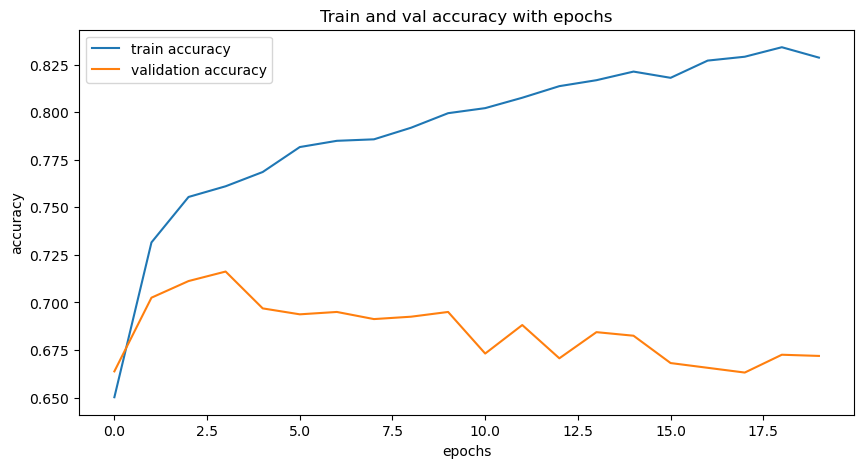

In [11]:
# plot train and val acc as a function of epochs
# your code here
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Train and val accuracy with epochs')
plt.legend()
plt.show()

In [12]:
# evaluate on train and test and print accuracy results
# your code here 
train_loss, train_acc = NN_model.evaluate(X_train_std, y_train, verbose=0)
test_loss, test_acc = NN_model.evaluate(X_test_std, y_test, verbose=0)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.8076
Test accuracy: 0.6710


<div class='exercise-r'>

**1.3**  **Bootstrap prediction intervals**

In HW1, we saw how we could use MCMC to perform Bayesian inference on the parameters of a logistic regression model. This gave us access not only to samples from the posterior distribution (betas) but we could also generate samples from the posterior predictive distribution (data). The posterior predictive can be used to represent our uncertainy about a given prediction, $\hat{y}$.

We'd like to do something similar for our neural network here so that we can quantify the uncertainty in our predictions. But there are some problems. First, we haven't (explicitly) specified any priors on the network weights. Second, and more serious, neural networks have many, many parameters. Far too many for MCMC to be a viable approach. Sampling in such a high dimensional space is simply intractable.

Bootstrap to the rescue!

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q13"></a>


</div>

In [13]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

In [14]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here
n = 50  
boot_preds = np.zeros((len(y_test), n))

y_train_np = y_train.to_numpy()

def build_nn_model():
    model = models.Sequential([
        layers.Dense(15, activation='relu', input_shape=(X_train_std.shape[1],)),
        layers.Dense(15, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

base_model = build_nn_model()
base_weights = base_model.get_weights()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

for i in range(n):
    progressbar(i, n)  

    boot_idx = np.random.choice(len(y_train_np), size=len(y_train_np), replace=True)
    X_boot, y_boot = X_train_std.iloc[boot_idx], y_train_np[boot_idx] 

    boot_model = build_nn_model()
    boot_model.set_weights(base_weights)

    boot_model.fit(X_boot, y_boot, epochs=50, batch_size=32, verbose=0, 
                   validation_split=0.2, callbacks=[early_stopping])  

    boot_preds[:, i] = boot_model.predict(X_test_std, verbose=0).flatten()

np.random.seed(109)
rand_idx = np.random.choice(len(y_test), size=8, replace=False)


 [==================================================] 50/50 Done...

CPU times: user 3min 41s, sys: 26 s, total: 4min 7s
Wall time: 2min 59s


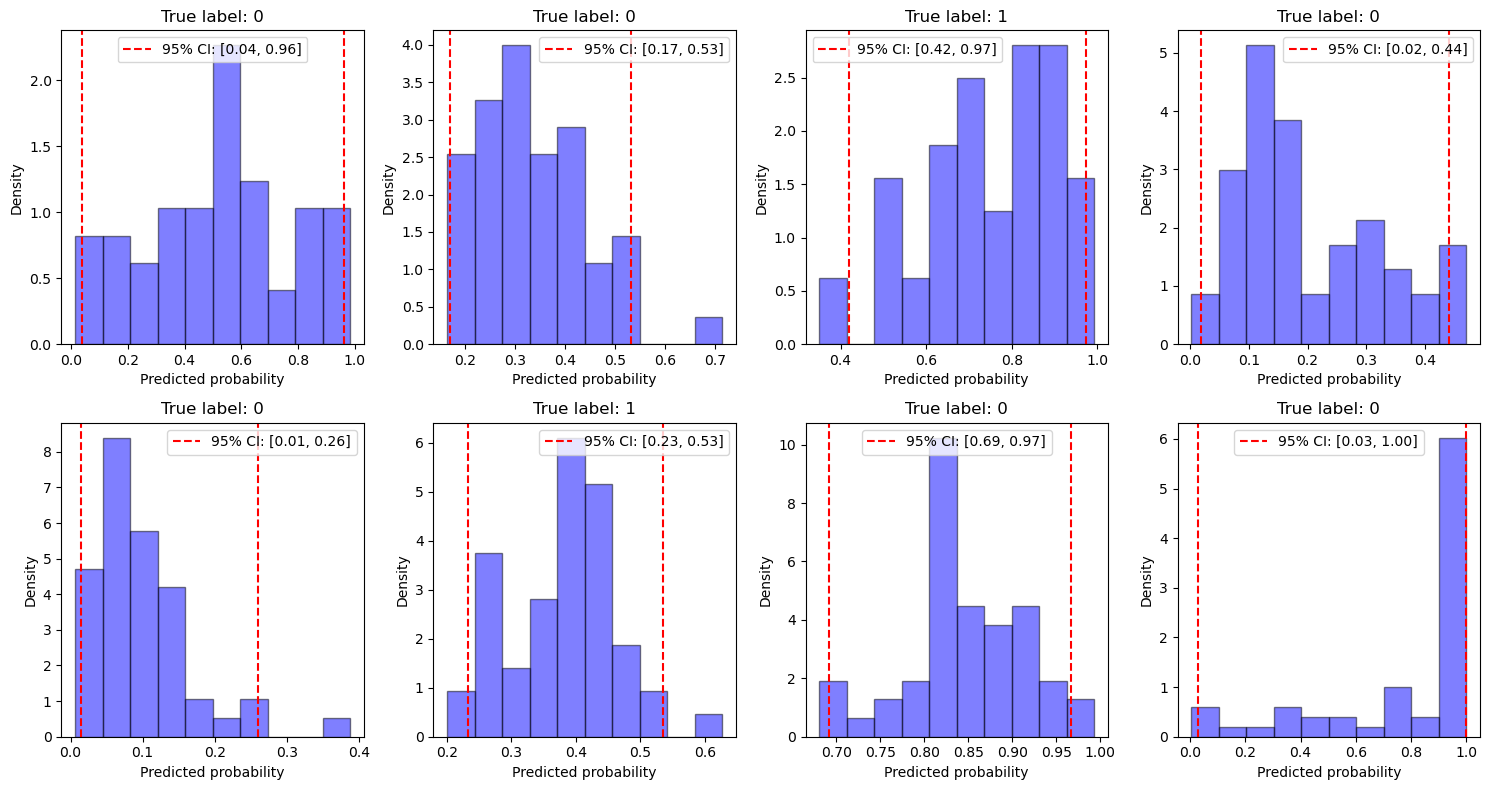

In [15]:
# generate your plot
# your code here
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flatten()

for ax, idx in zip(axes, rand_idx):
    pred_values = boot_preds[idx, :]
    true_class = y_test.iloc[idx]

    ci_lower, ci_upper = np.percentile(pred_values, [2.5, 97.5])

    ax.hist(pred_values, bins=10, color="blue", alpha=0.5, edgecolor="black", density=True)
    ax.axvline(ci_lower, color='red', linestyle='dashed', label=f"95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")
    ax.axvline(ci_upper, color='red', linestyle='dashed')

    ax.set_title(f"True label: {true_class}")
    ax.legend()
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()



# Answer
WE can see that the widths are pretty variable which demarcates differeing levels of prediction uncertainty. For example plot 5 (bottom left) has an interval of (0.04, 0.26) while others like plot 8 are large (bottom right) which has an interval of (0.04,1.00). Observations where CI crosses 0.5 measn that the model has trouble figuring out if it is delayed and on time. Finally, some dirstibutions are skewed towards 0 or 1, which means that the model is predicting the same outcome across bootstraps which is good, while others are more spread out which indicaates disagreement.

<div class='exercise-r'>

**1.4**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

Test accuracy full bagging: 0.7140


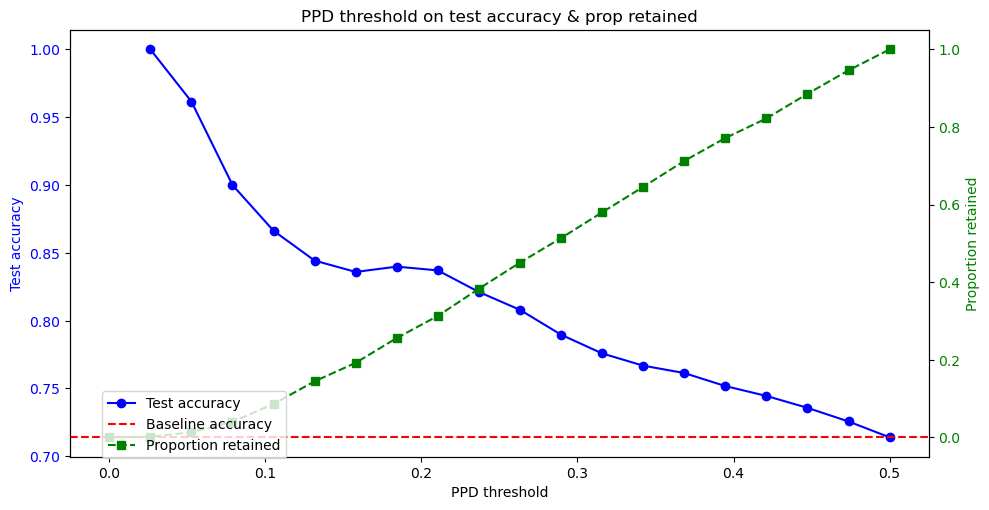

In [16]:
def calculate_ppd(predictions):
    avg_probs = np.mean(predictions, axis=1)
    return np.minimum(avg_probs, 1 - avg_probs)  

ppd_values = calculate_ppd(boot_preds)
y_pred_full = np.round(np.mean(boot_preds, axis=1))  
test_accuracy_full = np.mean(y_pred_full == y_test.values)

print(f"Test accuracy full bagging: {test_accuracy_full:.4f}")

ppd_thresholds = np.linspace(0, 0.5, 20)

test_accuracies = []
proportions_retained = []

for threshold in ppd_thresholds:
    retained_indices = ppd_values <= threshold
    retained_preds = boot_preds[retained_indices, :]
    
    if retained_preds.shape[0] > 0:
        y_pred = np.round(np.mean(retained_preds, axis=1))  
        y_true = y_test.values[retained_indices]
        accuracy = np.mean(y_pred == y_true)  
    else:
        accuracy = np.nan  

    test_accuracies.append(accuracy)
    proportions_retained.append(np.mean(retained_indices))

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("PPD threshold")
ax1.set_ylabel("Test accuracy", color="blue")
ax1.plot(ppd_thresholds, test_accuracies, marker="o", linestyle="-", color="blue", label="Test accuracy")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Proportion retained", color="green")
ax2.plot(ppd_thresholds, proportions_retained, marker="s", linestyle="--", color="green", label="Proportion retained")
ax2.tick_params(axis="y", labelcolor="green")

ax1.axhline(test_accuracy_full, linestyle="dashed", color="red", label="Baseline accuracy")

fig.tight_layout()
plt.title("PPD threshold on test accuracy & prop retained")
fig.legend(loc="lower left", bbox_to_anchor=(0.1, 0.1))
plt.show()



# Answer

We can see that as PPD treshold decreases the test accuracy increases signicicantly and this is because the model is stricter, making only confident predictions. It becomes close to 100% when only the most certain predictions are considered, however this means we are keeping less predictions like in the green line, which shows that as PPD is going down, we have less test sampels that are classified. At PPD of 0.5, the model is making predictions for all test observations, and so we see that it is at the baseline accuracy, which makes sense. 

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [50 pts]: The Quick, Draw!  Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)

Artificial neural networks (ANNs) are prone to overfitting, learning patterns specific to the training data that do not generalize to new data.

There are several methods to reduce ANN generalization error. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less likely to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization."



<a id="part2about"></a>

## The Quick, Draw! Dataset 

[Return to contents](#contents)


![](img/quickdrawpreview.jpg)



For this problem, we will be working with a modified version of the [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset), which is a large database of 50 million drawings across 345 categories, collected from players of the game [Quick, Draw!](https://quickdraw.withgoogle.com/).

For this homework, we will simplify the problem by using only 120,000 images across 10 different classes for training (this includes the data you will use for validation) and a test set of 30,000 images.


<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**The required `train.csv` and `test.csv` data files are available on [the "Data" tab of the CS1090B HW2 Kaggle Competition website](https://www.kaggle.com/t/f70f40cbdf44c3cfdb32a37dcb52ebe1). They are also included with this assignment in `data/quickdraw.zip`. (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `train.csv` is our training dataset and the `label` column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image.  `train.csv` has 120,000 samples.

- `test.csv` file mirrors the structure of the `train.csv` file **without** the class label column. We have added another column `id`. `id` is a unique identifier for each sample in the test set. This ID is crucial for mapping your model's predictions back to the corresponding samples when submitting your results to Kaggle. `test.csv` has 30,000 samples. 

- Since the `test.csv` does not include the true labels, it is used exclusively for generating predictions that you'll submit to Kaggle for evaluation.  Your task is to predict the class labels for each sample in `test.csv` and submit these predictions in the required format.


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `label` and needs to contain your class predictions (i.e. 'cat', 'dog' etc) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS1090B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/f70f40cbdf44c3cfdb32a37dcb52ebe1). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS1090B Kaggle competition, please see below and also review [the modeling restrictions DOS and DON'TS outlined in question 2.3.2](#q2.3.2).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.6 is worth 30 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** accuracy score using the formula:
$$
\text{relu}(\text{max}(30, 4.3\times 100\times(\text{score} - 0.78)))
$$

**🏆 Grand Prize(s):** The **Top-2** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS1090B teaching staff. This refers to the top 2 individuals on the board. The invitation will be extended to 3 students if the restriction to 2 would otherwise divide a group (e.g., 1 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 5 submissions per team per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW2 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW2 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the training and test data downloaded via the "Data" tab of [the CS1090B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Download and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `test.csv` in question 2.3.5 only. 
- Load the data and use the matplotlib function `imshow` to display 25 samples  from each of the 10 classes from the training set. Total of 250 samples, 10 rows of 25 images each.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

</div>

In [3]:
# read the data
df_train = pd.read_csv("data/quickdraw/train.csv")
df_test = pd.read_csv("data/quickdraw/test.csv")

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,255,255,255,255,0,0,0,255,255,255,...,255,255,255,255,255,255,255,255,255,swan
1,255,255,255,255,255,255,255,0,0,0,...,255,255,255,255,255,255,255,255,255,duck
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,swan
3,255,255,255,255,255,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,butterfly
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,skull


['swan' 'duck' 'butterfly' 'skull' 'tree' 'face' 'apple' 'dog' 'car' 'cat']


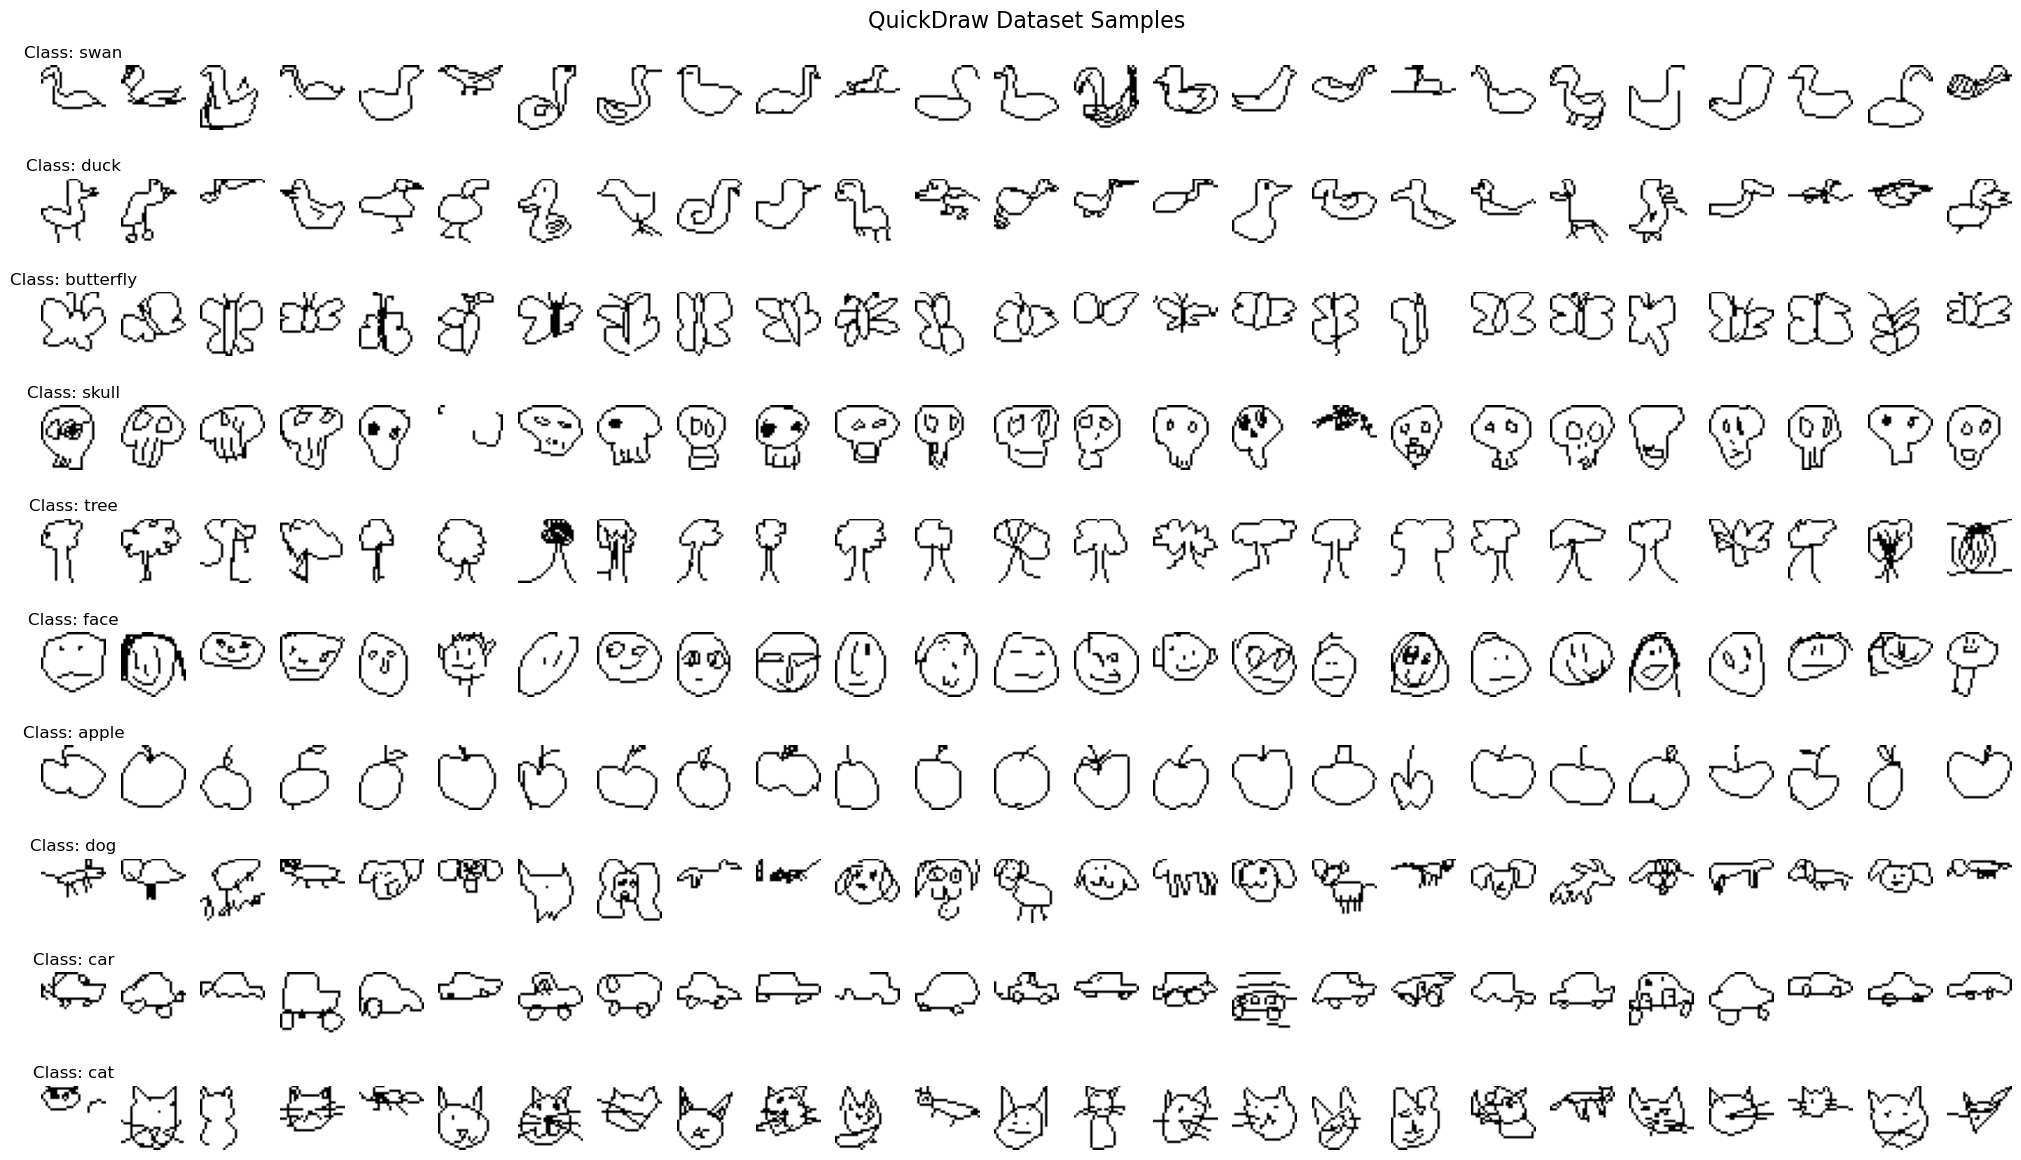

In [4]:
# quick inspection
display(df_train.head()) 

# visualization requirements
n_samples = 25
unique_classes = df_train['label'].unique()
n_classes = len(unique_classes)
print(unique_classes)

# create subplots figure
fig, axes = plt.subplots(n_classes, n_samples, figsize=(20, 12))

# create a copy of the dataframe with numeric pixel values 
pixel_columns = [col for col in df_train.columns if col != "label"]
df_train_numeric = df_train.copy()
df_train_numeric[pixel_columns] = df_train_numeric[pixel_columns].apply(pd.to_numeric, errors='coerce')

# iterate through each class
for i, class_label in enumerate(unique_classes):
    # get samples for this class
    class_samples = df_train_numeric[df_train_numeric["label"] == class_label]
    samples_to_display = class_samples.sample(n_samples)
    
    # display each sample
    for j, (_, sample) in enumerate(samples_to_display.iterrows()): # .iterrows() returns a tuple (index, row data)
        if j >= n_samples:
            break
                 
        # get pixel values, turn into Numpy array and process for imshow()
        pixel_values = sample.drop("label").values.astype(float)
        
        # reshape to 28x28 image
        image = pixel_values.reshape(28, 28)
        
        # display image
        axes[i, j].imshow(image, cmap='gray')
        axes[i, j].axis('off')
        
        # add class label to the first image in each row
        if j == 0:
            axes[i, j].set_title(f'Class: {class_label}')

plt.tight_layout()
plt.suptitle("QuickDraw Dataset Samples", fontsize=16)
plt.subplots_adjust(top=0.95) # make room for title
plt.show()

In [5]:
# make X and y
X_train = df_train.drop(columns=["label"])
y_train = df_train["label"].values
X_test = df_test.drop(columns=["id"])
test_id = df_test["id"].values

# encode labels and convert to categorical
labenc = LabelEncoder().fit(y_train)
y_enc = labenc.transform(y_train)
y_cat = to_categorical(y_enc, num_classes=10)

# scale X data by dividing by 255, as the values are either 0 or 255.
X_train_std = X_train / 255.
X_test_std = X_test / 255.

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 10000, 10000, 10000
- Activation function: ReLU 
- Loss function: sparse_categorical_crossentropy
- Output unit: Softmax 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 20
- Batch size: 128
- Validation size: 0.2

    
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 

</div>

In [6]:
# Helper function for plotting training history
def plot_history(model, title=None, ax=None, kaggle = False):
    if not kaggle:
        if ax is None:
            ax = plt.gca()
        ax.plot(model.history.history['acc'], label='Training Accuracy')
        ax.plot(model.history.history['val_acc'], label='Validation Accuracy')
        ax.set_xlabel('epoch')
        ax.set_ylabel('Accuracy')
        best_loss = np.nanmax(model.history.history['val_acc'])
        ax.axvline(np.nanargmax(model.history.history['val_acc']),
                    c='k', ls='--',
                    label=f'best val acc = {best_loss:.2f}')
        ax.legend()
        ax.set_title(title)
    elif kaggle:
        plt.figure()
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_val = np.max(history.history['val_accuracy'])
        plt.axvline(best_epoch, color='k', linestyle='--', label=f'Best val acc = {best_val:.2f}')
        plt.title(title if title else "Model Accuracy")
        plt.legend()
        plt.show()

In [21]:
# create the model with a sequential architecture
model_overfit = models.Sequential(name = 'model_overfit')
model_overfit.add(Dense(10000, activation='relu', input_shape=(X_train_std.shape[1],)))
model_overfit.add(Dense(10000, activation='relu'))
model_overfit.add(Dense(10000, activation='relu'))
model_overfit.add(Dense(y_cat.shape[1],activation='softmax')) # output layer with softmax activation for multi-class classification

model_overfit.summary()

# compile the model
model_overfit.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

Model: "model_overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 10000)             7850000   
                                                                 
 dense_157 (Dense)           (None, 10000)             100010000 
                                                                 
 dense_158 (Dense)           (None, 10000)             100010000 
                                                                 
 dense_159 (Dense)           (None, 10)                100010    
                                                                 
Total params: 207970010 (793.34 MB)
Trainable params: 207970010 (793.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/20
750/750 [==============================] - 42s 55ms/step - loss: 1.4640 - acc: 0.5531 - val_loss: 1.0327 - val_acc: 0.6543
Epoch 2/20
750/750 [==============================] - 41s 55ms/step - loss: 0.9426 - acc: 0.6860 - val_loss: 0.8708 - val_acc: 0.7095
Epoch 3/20
750/750 [==============================] - 41s 55ms/step - loss: 0.8153 - acc: 0.7258 - val_loss: 0.8238 - val_acc: 0.7238
Epoch 4/20
750/750 [==============================] - 41s 55ms/step - loss: 0.7434 - acc: 0.7488 - val_loss: 0.7612 - val_acc: 0.7468
Epoch 5/20
750/750 [==============================] - 42s 55ms/step - loss: 0.6997 - acc: 0.7635 - val_loss: 0.6878 - val_acc: 0.7652
Epoch 6/20
750/750 [==============================] - 42s 56ms/step - loss: 0.6571 - acc: 0.7769 - val_loss: 0.7110 - val_acc: 0.7657
Epoch 7/20
750/750 [==============================] - 42s 56ms/step - loss: 0.6352 - acc: 0.7831 - val_loss: 0.7057 - val_acc: 0.7607
Epoch 8/20
750/750 [==============================] - 42s 56ms

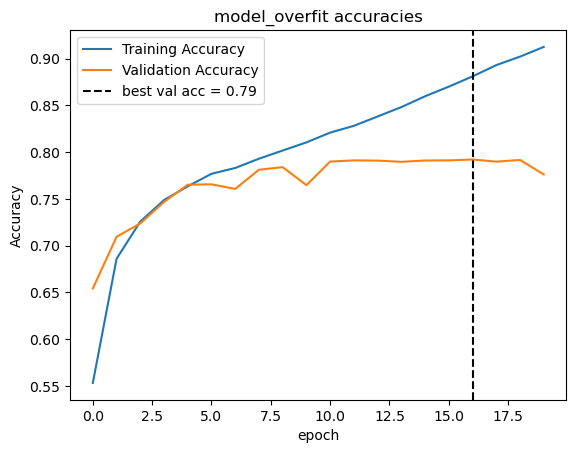

In [22]:
# fit stupidly large model
model_overfit.fit(
    X_train_std,   
    y_enc,
    epochs=20,
    batch_size=128,
    validation_split=0.2
)

# plot model_overfit accuracies
plot_history(model_overfit, title = "model_overfit accuracies")

# Answer

We can see that the model is overfitting because its training accuracy continues to increase with each additional epoch, while the validation accuracy does not improve in a similar manner. Observing that the training accuracy rises (and may eventually plateau) but the validation accuracy remains relatively stagnant is a clear indication of overfitting. In other words, the model is memorizing the training data at the expense of its ability to generalize.

<div class='exercise-r'>
<a id="q2.3.1"></a>

**2.3.1** **Enhancing Feature Extraction with Fourier Transforms**

Neural networks can learn useful representations of their inputs while simultaneously solving tasks like classification. This process, called **representation learning**, can be seen as a form of feature extraction. However, incorporating **explicit feature transformations** can still improve performance. One such transformation is the **Fourier Transform (FT)**, which decomposes an image into its frequency components. This alternative representation can highlight patterns that may not be easily captured in the pixel space. The **Fast Fourier Transform (FFT)** is an efficient algorithm for computing the FT.

Your task:
- **Implement a custom Keras layer** that applies the **FFT** to its input.
- **Incorporate this layer** into a neural network architecture for classifying the "Quick, Draw!" dataset.
- **Describe your approach**: Explain where and how you added the FFT layer, your reasoning behind it, and whether it improved performance compared to the previous model.

**Hints**
- Experiment with the [Functional Keras API](https://www.tensorflow.org/guide/keras/functional_api) and the [Concatenate layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate).
- You may find the following documentation helpful:
  - [TensorFlow FFT function](https://www.tensorflow.org/api_docs/python/tf/signal/fft2d)
  - [Building Custom Keras Layers](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

⚠️ **Note:** This question is worth 5 points out of the 100 possible points in the notebook, so allocate your time accordingly.
</div>

In [23]:
# FFT Layer
class FFTLayer(layers.Layer):
    def __init__(self, image_size=28, **kwargs):  # specify image size
        super(FFTLayer, self).__init__(**kwargs)
        self.image_size = image_size  

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # reshape input to (batch_size, image_size, image_size)
        images = tf.reshape(inputs, (batch_size, self.image_size, self.image_size))

        # compute 2D FFT
        fft = tf_signal.fft2d(tf.cast(images, tf.complex64))
        fft_abs = tf.abs(fft)

        # flatten back to (batch_size, image_size * image_size)
        fft_flat = tf.reshape(fft_abs, (batch_size, self.image_size * self.image_size))

        return fft_flat

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.image_size * self.image_size)  # Ensures correct shape


In [24]:
# define input
input_layer = Input(shape=(X_train_std.shape[1],))

# FFT Layer
fft_features = FFTLayer(image_size=28)(input_layer)  # ensure correct image size

# concatenate FFT features with original input
concatenated_features = Concatenate()([input_layer, fft_features])

# define Dense layers
x = Dense(10000, activation='relu')(concatenated_features)
x = Dense(10000, activation='relu')(x)
x = Dense(10000, activation='relu')(x)
output_layer = Dense(y_cat.shape[1], activation='softmax')(x)

# create fft model
model_fft = Model(inputs=input_layer, 
                  outputs=output_layer, 
                  name="model_with_fft")
model_fft.summary()

# compile the model
model_fft.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)


Model: "model_with_fft"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 fft_layer (FFTLayer)        (None, 784)                  0         ['input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 1568)                 0         ['input_2[0][0]',             
                                                                     'fft_layer[0][0]']           
                                                                                                  
 dense_160 (Dense)           (None, 10000)                1569000   ['concatenate[0][

Epoch 1/20
750/750 [==============================] - 44s 58ms/step - loss: 5.7121 - acc: 0.5404 - val_loss: 0.9636 - val_acc: 0.6685
Epoch 2/20
750/750 [==============================] - 43s 57ms/step - loss: 0.9242 - acc: 0.6827 - val_loss: 0.8152 - val_acc: 0.7232
Epoch 3/20
750/750 [==============================] - 43s 57ms/step - loss: 0.8466 - acc: 0.7100 - val_loss: 0.8632 - val_acc: 0.6963
Epoch 4/20
750/750 [==============================] - 43s 57ms/step - loss: 0.8050 - acc: 0.7237 - val_loss: 0.7784 - val_acc: 0.7376
Epoch 5/20
750/750 [==============================] - 43s 57ms/step - loss: 0.7610 - acc: 0.7388 - val_loss: 0.8597 - val_acc: 0.7096
Epoch 6/20
750/750 [==============================] - 43s 57ms/step - loss: 0.7333 - acc: 0.7494 - val_loss: 0.7581 - val_acc: 0.7381
Epoch 7/20
750/750 [==============================] - 43s 57ms/step - loss: 0.7214 - acc: 0.7533 - val_loss: 0.7442 - val_acc: 0.7460
Epoch 8/20
750/750 [==============================] - 43s 57ms

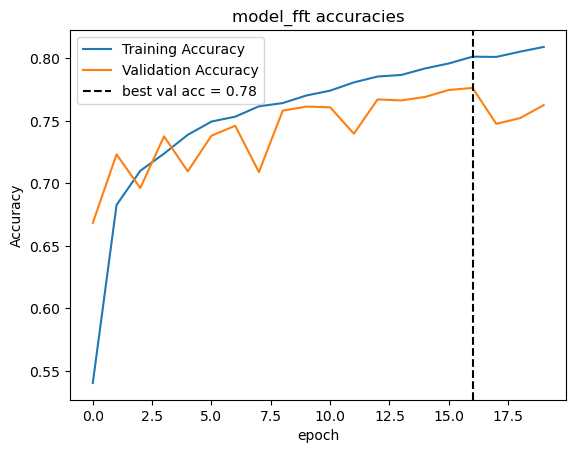

In [25]:
# fit stupidly large model
model_fft.fit(
    X_train_std,   
    y_enc,
    epochs=20,
    batch_size=128,
    validation_split=0.2
)

# plot model_fft accuracies
plot_history(model_fft, title = "model_fft accuracies")

# Answer

I added the FFT layer directly before feeding the data into the model, so the network receives frequency-transformed images as input. The main motivation for placing it there was the question’s prompt to transform the image data, and FFT made the most sense at the earliest stage—directly on the “raw” data—so the network could potentially learn frequency-based features from the start.

From the accuracy graph, you can see that while the training accuracy improves steadily (blue line), the validation accuracy (orange line) shows some fluctuations. Compared to the original overfit model (without FFT), the initial validation accuracy is lower. However, with more epochs, the validation accuracy continues to rise, suggesting that additional training might allow the FFT-transformed input to outperform or at least match the baseline.

A plausible reason for the slower improvement is that images may not exhibit clear “wave-like” features that benefit immediately from FFT, meaning the network may need more epochs to adapt to this frequency-domain representation. Ultimately, in a short training window, the FFT layer did not surpass the baseline model’s performance, but the positive trend in validation accuracy implies it could catch up or potentially exceed the baseline with extended training.

<div class='exercise-r'>
<a id="q2.3.2"></a>

**2.3.2**  **Kaggle Competition**

Create an ANN and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.2"></a>
    
**DON'TS**

- **No CNNs, transfer learning, RNNs, ensembles, and no ensembles with folds.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific dataset provided to you (via the CS1090B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model.
 - **YOU CAN** do data augmentation using the provided training data.
 - **YOU CAN** make use of your custom Fourier Transform layer from the previous question. 

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**

</div>

In [7]:
# reshape flattened images back to 28x28 
X_train_images = X_train_std.to_numpy().reshape(-1, 28, 28, 1) # 1 channel because of greyscale

# split into training and validation sets
X_train_img, X_val_img, y_train_split, y_val = train_test_split(
    X_train_images, y_cat, test_size=0.2, random_state=109
)

# flatten validation images (without augmentation) for evaluation
X_val_flat = X_val_img.reshape(-1, X_train_std.shape[1])

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05
)

# custom generator: threshold augmented images to binary and flatten them
def binary_flatten_generator(generator):
    while True:
        X_batch, y_batch = next(generator)
        # flatten images to shape (batch_size, 784)
        X_batch = X_batch.reshape(X_batch.shape[0], -1)
        yield X_batch, y_batch

# generator for training data
batch_size = 128  # adjustable as needed
train_generator = datagen.flow(X_train_img, 
                               y_train_split, 
                               batch_size=batch_size, 
                               shuffle=True)

train_gen = binary_flatten_generator(train_generator)

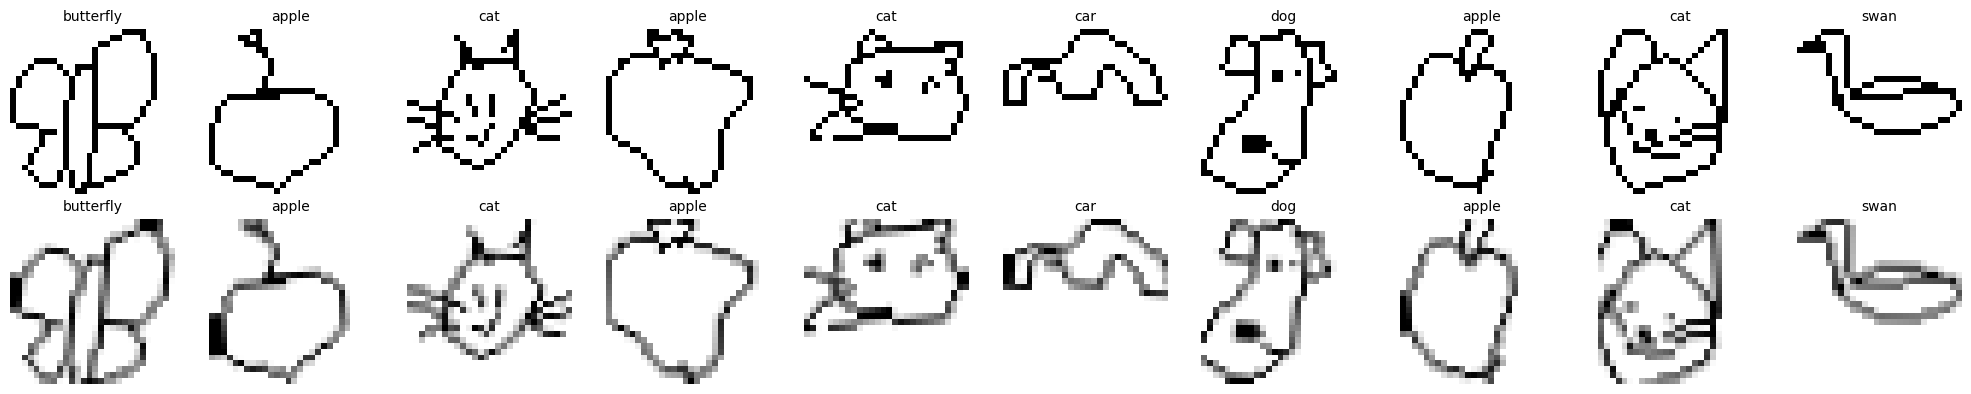

In [8]:
# randomly select 10 training images
random_indices = random.sample(range(len(X_train_img)), 10)

# create figure
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i, idx in enumerate(random_indices):
    # find image index and label
    original_img = X_train_img[idx] 
    numeric_label = np.argmax(y_train_split[idx])
    original_label = labenc.inverse_transform([numeric_label])[0]
    
    # plot the original image
    axes[0, i].imshow(original_img.squeeze(), cmap="gray")
    axes[0, i].set_title(f"{original_label}", fontsize=10)
    axes[0, i].axis('off')
    
    # generate an augmented version of the same image
    X_augmented = next(datagen.flow(original_img[np.newaxis, ...], batch_size=1, shuffle=False))
    
    # plot the augmented image
    axes[1, i].imshow(X_augmented.squeeze(), cmap="gray")
    axes[1, i].set_title(f"{original_label}", fontsize=10)
    axes[1, i].axis('off')

# set row labels
axes[0, 0].set_ylabel("Original", fontsize=12)
axes[1, 0].set_ylabel("Augmented", fontsize=12)

plt.tight_layout()
plt.show()


In [9]:
# ann model for kaggle
inputs = Input(shape=(X_train_std.shape[1],))
x = Dense(1024, activation='relu', kernel_initializer="he_uniform")(inputs)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)

x = Dense(512, activation='relu', kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)

x = Dense(256, activation='relu', kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)

x = Dense(128, activation='relu', kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)

x = Dense(64, activation='relu', kernel_initializer="he_uniform")(x)
x = BatchNormalization()(x)
x = Dropout(0.05)(x)

outputs = Dense(y_cat.shape[1], activation="softmax")(x)
model_ann = Model(inputs, outputs)

# additional model stuff
optimizer = Adam()

es = EarlyStopping(monitor="val_accuracy", 
                   patience=15, 
                   restore_best_weights=True)

def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        lr = lr * 0.5 # decrease learning rate every 20 epochs by 50%
    return lr
    
lr_scheduler = LearningRateScheduler(lr_schedule, 
                                     verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=5, 
                              verbose=1, min_lr=1e-6)

# Calculate steps per epoch based on training set size and batch size
steps_per_epoch = len(X_train_img) // batch_size

# compile model
model_ann.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

# fit the epic model
history = model_ann.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_val_flat, y_val),
    epochs=100,
    callbacks=[es, lr_scheduler, reduce_lr]
)

2025-03-05 22:17:52.123834: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20763 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:31:00.0, compute capability: 8.9



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/100


2025-03-05 22:17:54.775018: I external/local_xla/xla/service/service.cc:168] XLA service 0x14f14e24d110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-05 22:17:54.775051: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2025-03-05 22:17:54.779337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-05 22:17:54.796789: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1741231074.863636   22503 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 20s 21ms/step - loss: 0.9989 - accuracy: 0.6683 - val_loss: 0.8829 - val_accuracy: 0.6996 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/100
750/750 [==============================] - 16s 21ms/step - loss: 0.7721 - accuracy: 0.7421 - val_loss: 0.7334 - val_accuracy: 0.7507 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/100
750/750 [==============================] - 16s 21ms/step - loss: 0.7114 - accuracy: 0.7587 - val_loss: 0.7560 - val_accuracy: 0.7479 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/100
750/750 [==============================] - 16s 21ms/step - loss: 0.6671 - accuracy: 0.7726 - val_loss: 0.6099 - val_accuracy: 0.7920 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/100
750/750 [==============================] - 16s 2

In [10]:
# best validation accuracies
best_val_acc = max(history.history["val_accuracy"])
print(f"Best validation accuracy = {best_val_acc:.4f}")

Best validation accuracy = 0.8680


In [12]:
# ----------------------------
# 1) Combine Training + Validation Data
# ----------------------------
X_all_img = np.concatenate([X_train_img, X_val_img], axis=0)  # shape: (num_samples, 28, 28, 1)
y_all = np.concatenate([y_train_split, y_val], axis=0)

# ----------------------------
# 2) Create DataGenerator for All Data
# ----------------------------
all_generator = datagen.flow(X_all_img, y_all, batch_size=batch_size, shuffle=True)
steps_per_epoch = len(X_all_img) // batch_size

# ----------------------------
# 3) Flatten Generator
# ----------------------------
def flatten_generator(generator):
    """
    Yields batches where each image is flattened from (28, 28, 1) to (784,).
    """
    while True:
        X_batch, y_batch = next(generator)      # X_batch shape: (batch_size, 28, 28, 1)
        X_batch = X_batch.reshape(X_batch.shape[0], -1)  # Flatten to (batch_size, 784)
        yield X_batch, y_batch

# Wrap the original generator
all_gen = flatten_generator(all_generator)

# ----------------------------
# 4) Re-initialize (or reuse) Model with Best Weights
# ----------------------------
model_final = Model(inputs, outputs)  # same architecture that expects input_shape=(784,)
model_final.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

# If you want to reuse the best weights from your previous training:
model_final.set_weights(model_ann.get_weights())

# ----------------------------
# 5) (Optional) Learning Rate Schedule
# ----------------------------
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 20 == 0:
        return lr * 0.5  # Decrease LR by 50% every 20 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# ----------------------------
# 6) Train on All Data (No Validation)
# ----------------------------
history_final = model_final.fit(
    all_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # Adjust as needed
    callbacks=[lr_scheduler]  # Callbacks that don't rely on val metrics
)

# The model is now trained on the entire dataset. You can proceed to make predictions for Kaggle.



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
937/937 [==============================] - 21s 20ms/step - loss: 0.4359 - accuracy: 0.8495 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/50
937/937 [==============================] - 19s 20ms/step - loss: 0.4437 - accuracy: 0.8462 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/50
937/937 [==============================] - 19s 20ms/step - loss: 0.4430 - accuracy: 0.8464 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/50
937/937 [==============================] - 19s 20ms/step - loss: 0.4385 - accuracy: 0.8482 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/50
937/937 [==============================] - 19s 20ms/step - loss: 0.4393 - accuracy: 0.8476 - lr: 0.0010

Epoch 6: LearningRateSch

<div class='exercise-r'>

**2.3.3**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

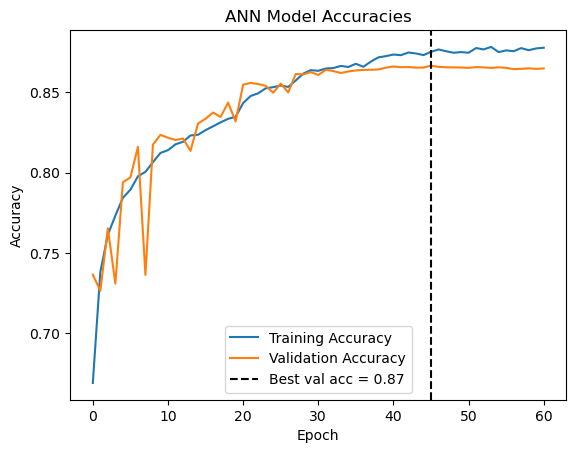

In [30]:
# plot kaggle_model accuracies
plot_history(model_ann, title="ANN Model Accuracies", kaggle = True)


<div class='exercise-r'>

**2.3.4**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.2 as well as any observations you might have regarding your training and Kaggle results.

</div>

# Answer

In the **regularized model**, I employed several strategies to mitigate overfitting and improve generalization. These included **data augmentation** to expand the effective training set, **batch size tuning**, and **early stopping** to halt training when validation performance stopped improving. I also **revised the network architecture** by adjusting the number of layers and nodes, and used a **robust weight initializer** (*he_uniform*). Additionally, I **introduced two variants of learning rate scheduling** to refine the training process. 

As shown in the **ANN Model Accuracies** figure, these changes achieved a more balanced relationship between training and validation accuracy compared to the overfit model, with a best validation accuracy of around **0.87**. However, there remains a discrepancy between these results and my current **Kaggle leaderboard score of 0.859**. One possible explanation is that the leaderboard reflects only **30% of the test data**, so the final score may shift once the complete test set is evaluated. Moreover, the test set might contain **unusual or “crazy” images** that the model never encountered during training, further impacting its performance. To resolve this discrepancy, I plan to investigate potential differences in **data distribution** or **evaluation metrics** that could account for the gap between local validation and Kaggle results.


<div class='exercise-r'>

**2.3.5**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS1090B Kaggle Competition](#part2kaggle) for leaderboard scoring. 

**IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"id"` and needs to contain the test observation index numbers corresponding to each of your 30,000 predictions, the second column must be named `"label"` and needs to contain your class predictions (i.e. `cat` or `dog` etc.) for each corresponding test observation index location. A sample submission file is provided on [Kaggle](https://www.kaggle.com/competitions/cs-109-b-hw-2-contest-2025/data?select=sample_submission.csv)
</div>

In [13]:
# generate predictions
y_pred_probs = model_final.predict(X_test_std)  # Predict class probabilities
y_pred_labels = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_pred_labels = labenc.inverse_transform(y_pred_labels)  # Map indices to class names

# create submission DataFrame
submission_df = pd.DataFrame({
    "id": test_id,  # Ensure test_id is correctly loaded from the test set
    "label": y_pred_labels  # Predicted class labels
})

# save to CSV 
submission_file = "submission.csv"
submission_df.to_csv(submission_file, index=False)

print(f"Submission file saved: {submission_file}")


938/938 [==============================] - 1s 1ms/step
Submission file saved: submission.csv


<div class='exercise-r'>

**2.3.6**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

**YOUR KAGGLE LEADERBOARD NAME:**

# Andrew & Xuanthe



<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

In [36]:
hours_spent_on_hw = 14.

# Answer

Most challenging aspects:

- Data Augmentation; the whole 'generator' aspect still doesn't make sense for me.
- Getting past benchmark 2; 50% of my hours went from increasing my ANN's validation accuracy from 0.82 to 0.86.
- Understanding why certain hyperparameters made my ANN better (like `steps_per_epoch`, or learning to use the different varying learning rate functions)
- Plotting the augmented data; another headache
- Using the `.flow` attribute of datagen
- The `FFTLayer`; I know it was only worth 5 points, but that doesn't mean it wasn't hard.
- Being careful with the `to_categorical` function, and the difference between `sparse_categorical_crossentropy` and `categorical_crossentropy`

Thankfully, I understood most of it what was happening conceptually. The coding implementation is always going to be a little tricky.

In [37]:
grader.check("q2.4")

q2.4 results: All test cases passed!

In [34]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

It took 47.53 minutes for this notebook to run


**This concludes HW2. Thank you!**